# ProShares Replication

## HBS Case

### *ProShares Hedge Replication ETF*

***

# Section 2:  Analyzing the Data

Use the data found on Canvas, in <b>'proshares analysis data.xlsx'</b>. 

It has monthly data on financial indexes and ETFs from `Aug 2011` through `May 2025`.

-----

## Question 2.1 

For the series in the "hedge fund series" tab, report the following summary statistics:

(a) mean

(b) volatility

(c) Sharpe ratio

Annualize these statistics.

In [1]:
# Question 2.1 (a) Code Here
import pandas as pd
import numpy as np

FILE_PATH = "../data/proshares_analysis_data.xlsx"
SHEET = "hedge_fund_series"

# Set first column as a Date index
df = pd.read_excel(FILE_PATH, sheet_name = SHEET)
df = df.rename(columns = {df.columns[0]: "Date"}).set_index("Date")

# Annualise mean (monthly returns * 12)
annualised_mean = df.astype(float).mean() * 12

print(annualised_mean.round(4))

HFRIFWI Index     0.0513
MLEIFCTR Index    0.0385
MLEIFCTX Index    0.0365
HDG US Equity     0.0269
QAI US Equity     0.0288
dtype: float64


In [2]:
# Question 2.1 (b) Code Here
# Annualise volatility (monthly std * sqrt(12))
annualised_vol = df.astype(float).std(ddof=1) * np.sqrt(12)

print(annualised_vol.round(4))

HFRIFWI Index     0.0588
MLEIFCTR Index    0.0552
MLEIFCTX Index    0.0551
HDG US Equity     0.0574
QAI US Equity     0.0498
dtype: float64


In [3]:
# Question 2.1 (c) Code Here
annualised_sharpe = annualised_mean / annualised_vol

print(annualised_sharpe.round(4))

HFRIFWI Index     0.8722
MLEIFCTR Index    0.6976
MLEIFCTX Index    0.6629
HDG US Equity     0.4684
QAI US Equity     0.5783
dtype: float64


-----

## Question 2.2

For the series in the "hedge fund series" tab, calculate the following statistics related to tail-risk:

(a) Skewness

(b) Excess Kurtosis (in excess of 3)

(c) VaR (.05) - the fifth quantile of historic returns

(d) CVaR (.05) - the mean of the returns at or below the fifth quantile

(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown period.

There is no need to annualize any of these statistics.

In [4]:
# Question 2.2 (a) Code Here
skewness = df.astype(float).skew()

print(skewness.round(4))

HFRIFWI Index    -0.9483
MLEIFCTR Index   -0.2900
MLEIFCTX Index   -0.2735
HDG US Equity    -0.2749
QAI US Equity    -0.4335
dtype: float64


In [5]:
# Question 2.2 (b) Code Here
excess_kurtosis = df.astype(float).kurt() - 3 # subtract 3 for _excess_ kurtosis

print(excess_kurtosis.round(4))

HFRIFWI Index     2.6574
MLEIFCTR Index   -1.3691
MLEIFCTX Index   -1.4102
HDG US Equity    -1.2235
QAI US Equity    -1.5508
dtype: float64


In [6]:
# Question 2.2 (c) Code Here
var_05 = df.astype(float).quantile(0.05)

print(var_05.round(4))

HFRIFWI Index    -0.0240
MLEIFCTR Index   -0.0270
MLEIFCTX Index   -0.0270
HDG US Equity    -0.0299
QAI US Equity    -0.0172
Name: 0.05, dtype: float64


In [7]:
# Question 2.2 (d) Code Here
cvar_05 = df.astype(float).apply(lambda x: x[x <= x.quantile(0.05)].mean())

print(cvar_05.round(4))

HFRIFWI Index    -0.0360
MLEIFCTR Index   -0.0350
MLEIFCTX Index   -0.0349
HDG US Equity    -0.0368
QAI US Equity    -0.0310
dtype: float64


In [8]:
# Question 2.2 (e) Code Here

def compute_max_daily_drawdown(df: pd.DataFrame):
    # use cummax and cummin to compute drawdown considering only past maxima
    roll_max = df.cummax()
    daily_drawdown = df/roll_max - 1.0
    max_daily_drawdown = daily_drawdown.cummin()
    return max_daily_drawdown

# Citation: Santoso, A. (2019). Accessed Oct 11, 2025 at https://quant.stackexchange.com/a/45407
print(compute_max_daily_drawdown(df).min())

HFRIFWI Index    -3.593686
MLEIFCTR Index   -2.221155
MLEIFCTX Index   -2.209247
HDG US Equity    -2.171167
QAI US Equity    -2.650649
dtype: float64


-----

## Question 2.3

For the series in the "hedge fund series" tab, run a regression of each against SPY (found in the "merrill factors" tab.) Include an intercept. Report the following regression-based statistics:

(a) Market Beta

(b) Treynor Ratio

(c) Information ratio

Annualize these three statistics as appropriate.

In [9]:
SPY_SHEET = 'merrill_factors'

merrill_factors = pd.read_excel(FILE_PATH, sheet_name = SPY_SHEET)
merrill_factors = merrill_factors.rename(columns = {merrill_factors.columns[0]: "Date"}).set_index("Date")
spy = merrill_factors['SPY US Equity']
merrill_factors.head()

# Align all datasets to common dates
common_dates = df.index.intersection(merrill_factors.index)

# Extract aligned data
funds = df.loc[common_dates]
benchmark = spy.loc[common_dates]
factors = merrill_factors.loc[common_dates]

# Display final dataset information
final_dataset_info = pd.DataFrame({
    'Metric': ['Common Dates', 'Number of Stocks', 'Date Range'],
    'Value': [
        f"{len(common_dates)} observations",
        f"{df.shape[1]} funds", 
        f"{common_dates[0].strftime('%Y-%m-%d')} to {common_dates[-1].strftime('%Y-%m-%d')}"
    ]
})
final_dataset_info

,Metric,Value
0,Common Dates,170 observations
1,Number of Stocks,5 funds
2,Date Range,2011-08-31 to 2025-09-30


In [10]:
# Question 2.3 (a) Code Here
import statsmodels.api as sm
# Get OLS metrics for factor decomposition

# Run regression for each hedge fund series
regression_results = {}
betas = {}

for fund in funds.columns:
    # For each fund, combine with SPY and drop NAs for that specific pair
    fund_spy_data = pd.concat([funds[fund], benchmark], axis=1)
    fund_spy_data.columns = [fund, 'SPY']
    
    # Drop rows where either this fund OR SPY has NAs
    clean_fund_spy = fund_spy_data.dropna()
    
    if len(clean_fund_spy) == 0:
        print(f"\n{fund}: No valid observations (all NAs)")
        continue
    
    # Prepare the independent variable (SPY with constant)
    X = sm.add_constant(clean_fund_spy['SPY'])
    
    # Run OLS regression: fund returns = alpha + beta * SPY returns
    model = sm.OLS(clean_fund_spy[fund], X).fit()
    regression_results[fund] = model
    betas[fund] = model.params['SPY']
    print(f"\n{fund} Regression Results:")
    print(f"Alpha/intercept: {model.params['const']:.6f}")
    print(f"Beta: {model.params['SPY']:.6f}")
    print(f"R-squared: {model.rsquared:.6f}")
    print(f"Number of observations: {model.nobs}")
    print("-" * 50)

print(f"\nMarket betas:")
for fund, beta in betas.items():
    print(f"{fund}: {beta:.6f}")


HFRIFWI Index Regression Results:
Alpha/intercept: 0.000144
Beta: 0.346312
R-squared: 0.716217
Number of observations: 169.0
--------------------------------------------------

MLEIFCTR Index Regression Results:
Alpha/intercept: -0.000920
Beta: 0.342487
R-squared: 0.790416
Number of observations: 170.0
--------------------------------------------------

MLEIFCTX Index Regression Results:
Alpha/intercept: -0.001075
Beta: 0.341483
R-squared: 0.789721
Number of observations: 170.0
--------------------------------------------------

HDG US Equity Regression Results:
Alpha/intercept: -0.001989
Beta: 0.350602
R-squared: 0.767456
Number of observations: 170.0
--------------------------------------------------

QAI US Equity Regression Results:
Alpha/intercept: -0.001235
Beta: 0.301413
R-squared: 0.752559
Number of observations: 170.0
--------------------------------------------------

Market betas:
HFRIFWI Index: 0.346312
MLEIFCTR Index: 0.342487
MLEIFCTX Index: 0.341483
HDG US Equity: 0.350

In [11]:
# Question 2.3 (b) Code Here
treynor_ratios = {}

for fund in funds.columns:
    excess_returns = annualised_mean/12 - benchmark.mean()
    treynor_ratios[fund] = excess_returns[fund] / betas[fund]

print(f"\nTreynor ratios:")
for fund, tr in treynor_ratios.items():
    print(f"{fund}: {tr:.6f}")


Treynor ratios:
HFRIFWI Index: -0.022490
MLEIFCTR Index: -0.025842
MLEIFCTX Index: -0.026408
HDG US Equity: -0.028014
QAI US Equity: -0.032052


In [12]:
# Question 2.3 (c) Code Here
info_ratios = {}

for fund in funds.columns:
    alpha = regression_results[fund].params['const']
    te = regression_results[fund].resid.std(ddof=1) # Tracking error is the standard deviation of residuals
    info_ratios[fund] = alpha/te
    
print(f"\nInformation ratios:")
for fund, ir in info_ratios.items():
    print(f"{fund}: {ir:.6f}")


Information ratios:
HFRIFWI Index: 0.015974
MLEIFCTR Index: -0.125989
MLEIFCTX Index: -0.147383
HDG US Equity: -0.248949
QAI US Equity: -0.172569


-----

## Question 2.4

Discuss the previous statistics, and what they tell us about...

(a) the differences between SPY and the hedge-fund series?

(b) which performs better between HDG and QAI.

(c) whether HDG and the ML series capture the most notable properties of HFRI.

### Question 2.4 (a) Answer

The hedge fund series tends to have lower volatility at the cost of lower returns, as seen by their negative Treynor ratios. While their betas are relatively low, their R-squared values against SPY are still high at over 0.7 across the board.

Negative excess returns against SPY and strong correlations mean the little unexplained variance left makes information ratios more negative. 

### Question 2.4 (b) Answer

The performance of the two funds is close, but QAI arguably performs better. It achieves a superior Sharpe ratio, at a lower market beta and higher mean returns. Those figures are reflected in the other statistics. QAI did have a worse _worst_ daily drawdown, but among the bottom 5\% of returns it averaged a lower one.

### Question 2.4 (c) Answer

HDG and the ML series capture much of the characteristics of HFRI. They performed a tad worse over the sample, with a significant gap in Sharpe ratios, and negative alphas. HFRI has somewhat lower correlation with SPY.

-----

## Question 2.5 

Report the correlation matrix for these assets.

(a) Show the correlations as a heat map.

(b) Which series have the highest and lowest correlations?

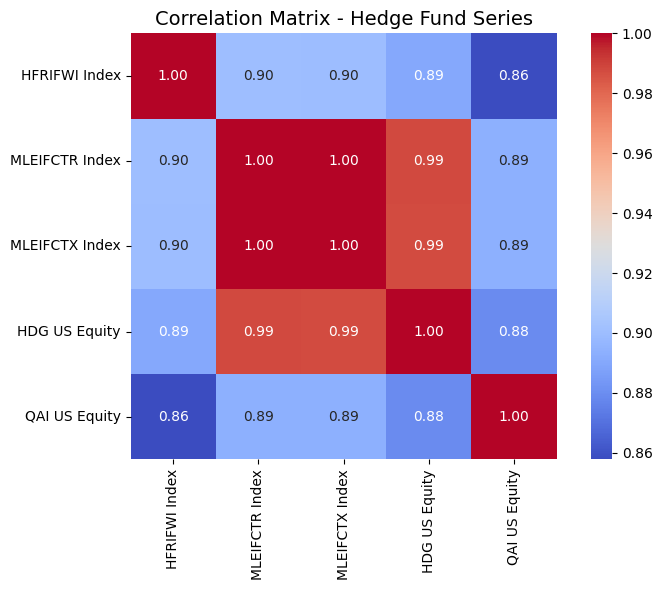

In [13]:
# Question 2.5 (a) Code Here
# Correlation Matrix
corr_matrix = df.astype(float).corr()

# Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix - Hedge Fund Series", fontsize=14)
plt.tight_layout()
plt.show()

In [14]:
# Qustion 2.5 (b) Code Here
# Upper Triangle
corr_pairs = (
    corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))
    .stack()
)

# Find the highest and lowest correlation pairs
highest_corr = corr_pairs.idxmax(), corr_pairs.max().round(4)
lowest_corr = corr_pairs.idxmin(), corr_pairs.min().round(4)

print("Highest correlation:", highest_corr)
print("Lowest correlation:", lowest_corr)

Highest correlation: (('MLEIFCTR Index', 'MLEIFCTX Index'), np.float64(0.9999))
Lowest correlation: (('HFRIFWI Index', 'QAI US Equity'), np.float64(0.8578))


-----

## Question 2.6  

Replicate HFRI with the six factors listed on the "merrill factors" tab. Include a constant, and run the unrestricted regression,  

$$
\begin{aligned}
r_t^{\mathrm{HFRI}} &= \alpha^{\mathrm{merr}} + x_t^{\mathrm{merr}}\beta^{\mathrm{merr}} + \epsilon_t^{\mathrm{merr}} \\[6pt]
\hat r_t^{\mathrm{HFRI}} &= \hat\alpha^{\mathrm{merr}} + x_t^{\mathrm{merr}}\hat\beta^{\mathrm{merr}}
\end{aligned}
$$  

Note that the second equation is just our notation for the fitted replication.  

(a) Report the intercept and betas.  

(b) Are the betas realistic position sizes, or do they require huge long-short positions?  

(c) Report the R-squared.  

(d) Report the volatility of $\epsilon^{\mathrm{merr}}$, the tracking error.  


In [15]:
# Question 2.6 (a) Code Here
# Get OLS metrics for factor decomposition
# run regression on HFRI using Merrill factors
hfri_col = 'HFRIFWI Index'
hfri = funds[hfri_col]

# For each fund, combine with SPY and drop NAs for that specific pair
hfri_factors = pd.concat([hfri, factors], axis=1)

# Drop rows where either this fund OR SPY has NAs
clean_hfri_factors = hfri_factors.dropna()
# Prepare the independent variables (factors with constant)
X = sm.add_constant(clean_hfri_factors[factors.columns])

# Run OLS regression: fund returns = alpha + beta * SPY returns
model = sm.OLS(clean_hfri_factors[hfri_col], X).fit()
print(f"\nRegression Results:")
print(f"Alpha/intercept: {model.params['const']:.6f}")
print(f"Number of observations: {model.nobs}")
for factor in factors.columns:
    print(f"{factor} beta: {model.params[factor]:.6f}")
    print("-" * 50)


Regression Results:
Alpha/intercept: 0.001149
Number of observations: 169.0
SPY US Equity beta: 0.043503
--------------------------------------------------
USGG3M Index beta: 0.324931
--------------------------------------------------
EEM US Equity beta: 0.085564
--------------------------------------------------
EFA US Equity beta: 0.073994
--------------------------------------------------
EUO US Equity beta: 0.029614
--------------------------------------------------
IWM US Equity beta: 0.145824
--------------------------------------------------


### Question 2.6 (b)
The betas all being below 0.32, with 5/6 below 0.15, they seem like realistic position sizes.

In [16]:
# Question 2.6 (c) Code Here
print(f"R-squared: {model.rsquared:.6f}")

R-squared: 0.842694


In [17]:
# Question 2.6 (d) Code Here
print(f"Volatility of tracking error: {model.resid.std()}")

Volatility of tracking error: 0.006731819236592868


-----

## Question 2.7  

Let's examine the replication out-of-sample (OOS).  

Starting with $t = 61$ month of the sample, do the following:  

(a) Use the previous 60 months of data to estimate the regression equation.  
This gives time-t estimates of the regression parameters, $\tilde{\alpha}^{\mathrm{merr}}_{t}$ and $\tilde{\beta}^{\mathrm{merr}}_{t}$.  

(b) Use the estimated regression parameters, along with the time-t regressor values, $x^{\mathrm{merr}}_{t}$, calculate the time-t replication value that is, with respect to the regression estimate, built "out-of-sample" (OOS).  

$$
\hat r_t^{\mathrm{HFRI}} \equiv \tilde{\alpha}^{\mathrm{merr}} + (x_t^{\mathrm{merr}})^\prime \tilde{\beta}^{\mathrm{merr}}
$$  

(c) Step forward to $t = 62$, and now use $t = 2$ through $t = 61$ for the estimation. Re-run the steps above, and continue this process throughout the data series. Thus, we are running a rolling, 60-month regression for each point-in-time.  

(d) How well does the out-of-sample replication perform with respect to the target?  


In [18]:
# Question 2.7 (a) Code Here
start_time = 0
SAMPLE_SIZE = 60

# Run OLS regression: fund returns = alpha + beta^T * factors
X = sm.add_constant(clean_hfri_factors[factors.columns].iloc[start_time:(SAMPLE_SIZE)])
model = sm.OLS(clean_hfri_factors[hfri_col].iloc[start_time:SAMPLE_SIZE], X).fit()

print(f"\n{SAMPLE_SIZE}-day regression results:")
print(f"Alpha/intercept: {model.params['const']:.6f}")
print(f"R-squared: {model.rsquared:.6f}")
print(f"Number of observations: {model.nobs}")
for factor in factors.columns:
    print(f"{factor} beta: {model.params[factor]:.6f}")
    print("-" * 50)


60-day regression results:
Alpha/intercept: -0.000437
R-squared: 0.858827
Number of observations: 60.0
SPY US Equity beta: 0.088883
--------------------------------------------------
USGG3M Index beta: 10.177090
--------------------------------------------------
EEM US Equity beta: 0.049401
--------------------------------------------------
EFA US Equity beta: 0.120784
--------------------------------------------------
EUO US Equity beta: 0.023246
--------------------------------------------------
IWM US Equity beta: 0.073647
--------------------------------------------------


In [19]:
# Question 2.7 (b) Code Here
X_oos = clean_hfri_factors[factors.columns].iloc[SAMPLE_SIZE:SAMPLE_SIZE+1]
# Convert to numpy array and add constant manually
X_oos_array = X_oos.values  # Shape: (1, 6)
X_oos_with_const = np.column_stack([np.ones(X_oos_array.shape[0]), X_oos_array])  # Shape: (1, 7)
r_t_plus_1 = model.predict(X_oos_with_const)
print(r_t_plus_1)

[0.00496643]


In [20]:
# Question 2.7 (c) Code Here
predictions = []
SAMPLE_SIZE = 60

for start_time in range(1, len(clean_hfri_factors) - SAMPLE_SIZE):

    # Run OLS regression: fund returns = alpha + beta^T * factors
    X = sm.add_constant(clean_hfri_factors[factors.columns].iloc[start_time:(start_time+SAMPLE_SIZE)])
    model = sm.OLS(clean_hfri_factors[hfri_col].iloc[start_time:(start_time+SAMPLE_SIZE)], X).fit()

    X_oos = clean_hfri_factors[factors.columns].iloc[start_time+SAMPLE_SIZE:start_time+SAMPLE_SIZE+1]
    # Convert to numpy array and add constant manually
    X_oos_array = X_oos.values  # Shape: (1, 6)
    X_oos_with_const = np.column_stack([np.ones(X_oos_array.shape[0]), X_oos_array])  # Shape: (1, 7)
    r_t_plus_1 = model.predict(X_oos_with_const)
    predictions.append(r_t_plus_1)

In [21]:
# Question 2.7 (d) Code Here
# Calculate residuals (actual - predicted)
actual_returns = clean_hfri_factors[hfri_col].iloc[SAMPLE_SIZE+1:]  # Actual HFRI returns
predicted_returns = np.array(predictions).flatten()  # Your predictions
residuals = actual_returns - predicted_returns

# Tracking error (annualized)
tracking_error = residuals.std() * np.sqrt(12)
print(f"Tracking Error (Annualized): {tracking_error:.4f}")
# Information ratio = (Excess Return) / (Tracking Error)
excess_return = (actual_returns - predicted_returns).mean() * 12  # Annualized
information_ratio = excess_return / tracking_error
print(f"Information Ratio: {information_ratio:.4f}")
# OOS R-squared
ss_res = np.sum((actual_returns - predicted_returns) ** 2)
ss_tot = np.sum((actual_returns - actual_returns.mean()) ** 2)
oos_r_squared = 1 - (ss_res / ss_tot)
print(f"Out-of-Sample R-squared: {oos_r_squared:.4f}")
mae = np.mean(np.abs(actual_returns - predicted_returns))
print(f"Mean Absolute Error: {mae:.4f}")

Tracking Error (Annualized): 0.0276
Information Ratio: 0.5959
Out-of-Sample R-squared: 0.8055
Mean Absolute Error: 0.0057


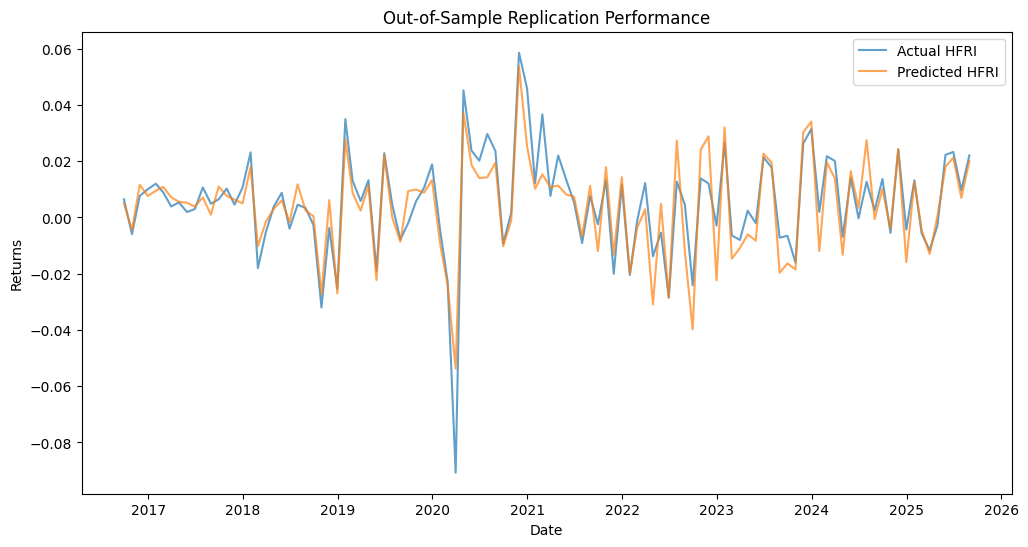

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_returns.index, actual_returns, label='Actual HFRI', alpha=0.7)
plt.plot(actual_returns.index, predicted_returns, label='Predicted HFRI', alpha=0.7)
plt.title('Out-of-Sample Replication Performance')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

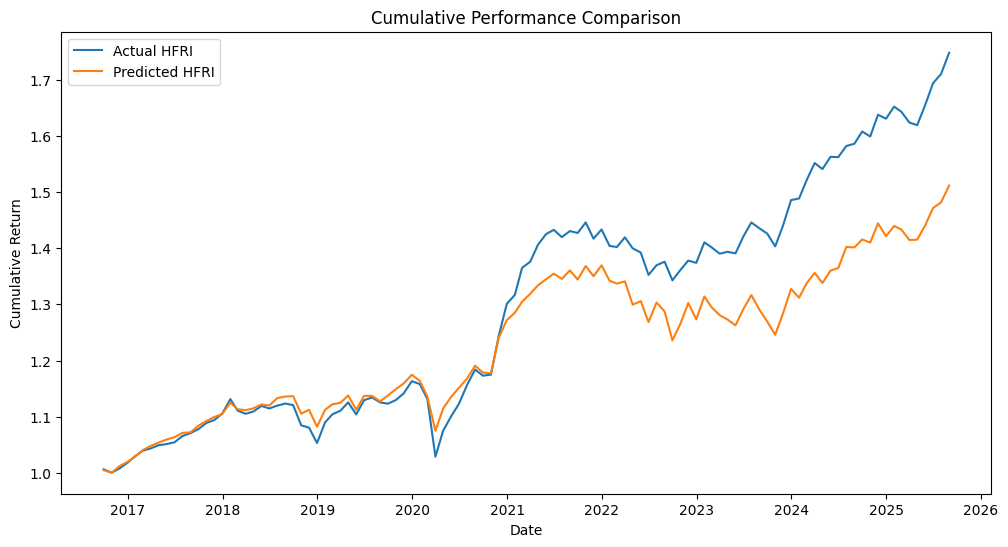

In [23]:
# Cumulative returns
cumulative_actual = (1 + actual_returns).cumprod()
cumulative_predicted = (1 + predicted_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_actual.index, cumulative_actual, label='Actual HFRI')
plt.plot(cumulative_actual.index, cumulative_predicted, label='Predicted HFRI')
plt.title('Cumulative Performance Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

The out of sample replication seems to perform well. Over time, however, differences compound such that cumulative returns are predicted to be more than 20 pp below actual performance.